In [1]:
import os

import pandas as pd
import numpy as np
from numpy import array
import pandas_datareader.data as pdr 

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import plotly.express as px
import plotly.graph_objects as go
from scipy.ndimage import zoom

import seaborn as sns
plt.style.use('seaborn-whitegrid')
from pylab import rcParams
%matplotlib inline
import itertools

import warnings 
warnings.filterwarnings(action='ignore')

import scipy.stats
from scipy.stats import norm,t

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

In [2]:
#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [3]:
pd.set_option('display.max_columns', None)
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.shape)
data.head()

(270, 10)


,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2000-01-31,570720,1319,1.913430,2.878875,4.039038,55.0,-218.1,1131.07,181367,133.88
2000-02-29,590400,1531,1.986905,2.882456,4.005537,51.9,-324.1,1128.80,218300,130.56
2000-03-31,665430,1660,2.050943,2.884831,4.038299,58.7,275.3,1117.19,206116,128.19
2000-04-30,603930,1628,2.107499,2.887110,4.030758,56.9,-1156.0,1109.76,166931,126.84
2000-05-31,683880,1566,2.158143,2.890466,4.022112,59.6,1535.5,1120.01,208853,127.89


In [4]:
split = -60
train_data = data['TEU'][0:split] 
test_data = data['TEU'][split:]

In [5]:
train_data.shape,test_data.shape

((210,), (60,))

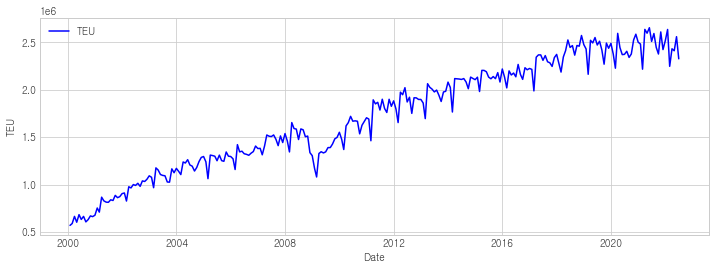

In [6]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(data['TEU'], 'blue', label='TEU')
plt.legend()

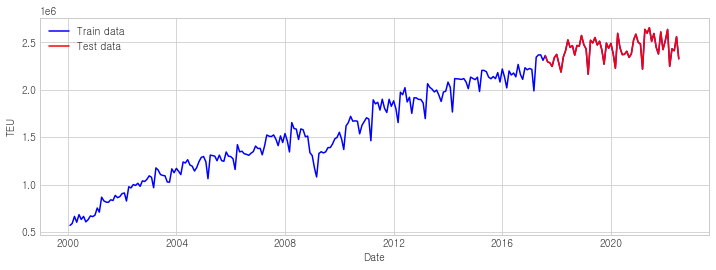

In [7]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(data['TEU'], 'blue', label='Train data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()

In [8]:
seasonal = pd.read_csv('계절성예측.csv')

In [9]:
pd.set_option('display.max_columns', None)
trend = pd.read_csv('TEU분해.csv')
trend['Date'] = pd.to_datetime(trend['Date'])
trend = trend.set_index('Date')
print(trend.shape)
trend.head()

(60, 1)


,TEU_Trend
Date,
2017-07-31,2291408.583
2017-08-31,2302073.625
2017-09-30,2310450.375
2017-10-31,2312407.958
2017-11-30,2320814.042


### 2. 다변량 LSTM

In [10]:
import tensorflow 
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense,Flatten,Dropout,GRU,Bidirectional,RepeatVector,TimeDistributed

In [11]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K

In [12]:
import random
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

In [13]:
tf.random.uniform([1]).numpy()

array([0.5380393], dtype=float32)

In [14]:
raw_df = data

In [15]:
split = -80
train = raw_df[0:split] 
test = raw_df[split:] 

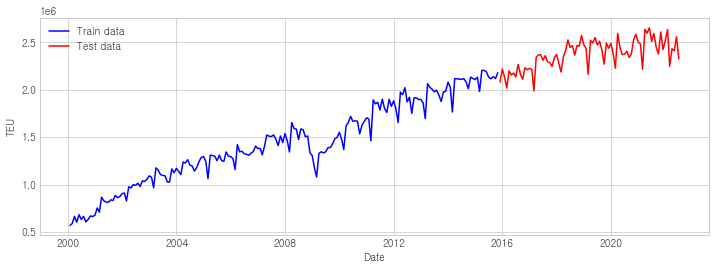

In [16]:
plt.figure(figsize=(12,4))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.plot(train['TEU'], 'blue', label='Train data')
plt.plot(test['TEU'], 'red', label='Test data')
plt.legend()

In [17]:
len(train),len(test)

(190, 80)

In [18]:
data.columns

Index(['TEU', 'BDI', 'ln(HRCI)', 'ln(SCFI)', 'ln(다우존스지수)', '전산업생산지수', '경상수지',
       '환율', '화물수송총괄', '수출물가지수'],
      dtype='object')

In [19]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scale_cols =  ['TEU','BDI', 'ln(HRCI)', 'ln(SCFI)','수출물가지수','환율','전산업생산지수','경상수지','ln(다우존스지수)','화물수송총괄']
scaled_train = scaler.fit_transform(train[scale_cols])  
scaled_train = pd.DataFrame(scaled_train, columns=scale_cols)

feature_train = scaled_train                       # X_train 다변량 시계열 변수 
label_train = scaled_train[['TEU']]               #  y_train 종속변수 

scaled_test = scaler.fit_transform(test[scale_cols]) 
scaled_test = pd.DataFrame(scaled_test, columns=scale_cols)

feature_test = scaled_test                       # X_test 다변량 시계열 변수 
label_test = scaled_test[['TEU']]               #  y_test종속변수 

In [20]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [21]:
window_size = 20 # Input Sequence (입력 길이) : X1,X2,....XT 
n_step_out = 60   # Output Sequence (출력 길이) : Y1,Y2,....YT

### 1. X_train, Y_train 배열

In [22]:
X_train,y = split_sequence(feature_train, window_size, n_step_out) # feature_train = X 다변량 변수 
x, Y_train = split_sequence(label_train, window_size, n_step_out) # label_train = Y 종속변수 예측값 

In [23]:
X_train.shape,Y_train.shape

((111, 20, 10), (111, 60, 1))

### 2. X_test,Y_test 배열

In [24]:
X_test,y = split_sequence(feature_test, window_size, n_step_out) # feature_train = X 다변량 변수 
x, Y_test = split_sequence(label_test, window_size, n_step_out) # label_train = Y 종속변수 예측값 

In [25]:
X_test.shape,Y_test.shape

((1, 20, 10), (1, 60, 1))

In [26]:
class MCDropout(Dropout): # 몬테카를로 드롭아웃 
    def call(self, inputs):
        return super().call(inputs, training=True)

In [27]:
from tcn import TCN, tcn_full_summary

In [28]:
model = Sequential() # Encoder & Decoder

## Encoder state
model.add(TCN(nb_filters=48,kernel_size=2,activation='tanh',padding='causal',input_shape=(X_train.shape[1], X_train.shape[2]),return_sequences=False,dilations=(1, 2, 4, 8, 16, 20)))

model.add(MCDropout(0.8))
model.add(Dense(1))
model.add(RepeatVector(60)) # 출력 개수만큼 반복 

## Decoder State
model.add(TCN(nb_filters=48, activation='tanh', return_sequences=True))  # Decoder State 
model.add(MCDropout(0.8))
model.add(TimeDistributed(Dense(8,activation='relu'))) 
model.add(TimeDistributed(Dense(1)))

model.compile(loss='mean_squared_error', optimizer='adam',metrics='mae')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(X_train, Y_train, epochs= 200, batch_size=10, validation_split=0.02,callbacks=[early_stop])

Epoch 1/200
11/11 [==============================] - 21s 965ms/step - loss: 7.3401 - mae: 1.9223 - val_loss: 0.8454 - val_mae: 0.7197
Epoch 2/200
11/11 [==============================] - 0s 43ms/step - loss: 0.7810 - mae: 0.6562 - val_loss: 0.4324 - val_mae: 0.5596
Epoch 3/200
11/11 [==============================] - 0s 42ms/step - loss: 0.3498 - mae: 0.4599 - val_loss: 0.3042 - val_mae: 0.4732
Epoch 4/200
11/11 [==============================] - 0s 39ms/step - loss: 0.2169 - mae: 0.3695 - val_loss: 0.2631 - val_mae: 0.4382
Epoch 5/200
11/11 [==============================] - 0s 45ms/step - loss: 0.1739 - mae: 0.3324 - val_loss: 0.2355 - val_mae: 0.4200
Epoch 6/200
11/11 [==============================] - 0s 39ms/step - loss: 0.1572 - mae: 0.3149 - val_loss: 0.2265 - val_mae: 0.4166
Epoch 7/200
11/11 [==============================] - 0s 39ms/step - loss: 0.1285 - mae: 0.2893 - val_loss: 0.2913 - val_mae: 0.4711
Epoch 8/200
11/11 [==============================] - 0s 42ms/step - loss: 

In [29]:
rcParams['figure.figsize'] = 12, 4

<AxesSubplot:>

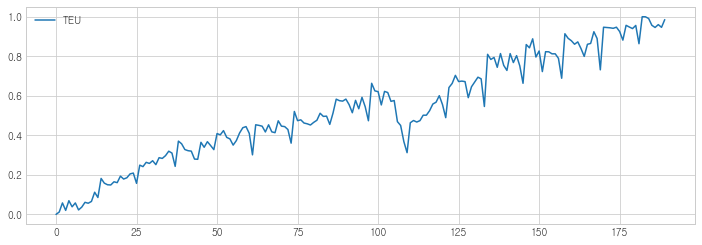

In [30]:
label_train.plot()

<AxesSubplot:>

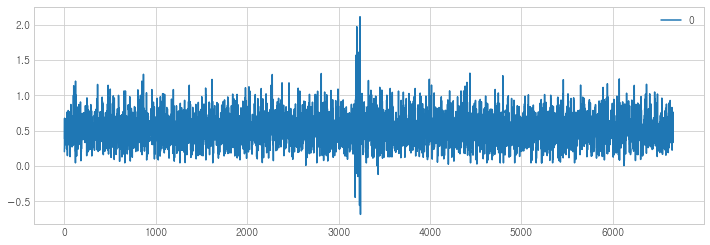

In [31]:
pd.DataFrame(model.predict(X_train).reshape(-1,1)).plot()

### Test 데이터 Sequence 반복 이동 예측 ( 총합 5번 시행)

In [32]:
X_test_1 = np.array(feature_test.head(20)).reshape((1,20, 10)) 

In [33]:
model_MC=  model
prediction = [model_MC.predict(X_test_1) for sample in range(30)]

In [34]:
dfs = [] # List 
for i in range(30): # 100번 반복 실험 
    fit = prediction[i].reshape(-1,1)
    fit_repeat = np.repeat(fit,10, axis=-1)
    model_fit = scaler.inverse_transform(fit_repeat)
    model_fit = np.squeeze(model_fit)[:,0]
    df = pd.DataFrame(model_fit)
    dfs.append(df)

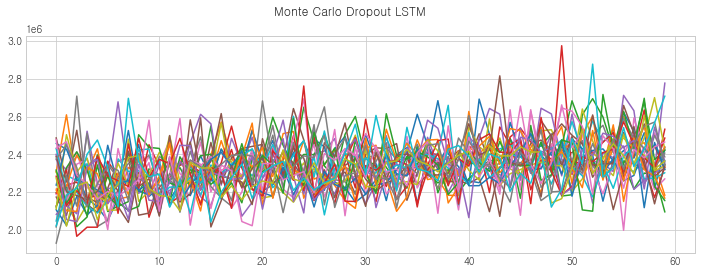

In [35]:
rcParams['figure.figsize'] = 12, 4
plt.suptitle('Monte Carlo Dropout LSTM')
for i in range(0,30):
    plt.plot(pd.DataFrame(np.array(dfs)[i])) 

In [36]:
for i in range(0,30): # 1. df 
    df = pd.DataFrame(np.array(dfs)[i])

In [37]:
for i in range(0,30): # 2.df[i]
    df[i] = pd.DataFrame(np.array(dfs)[i])

In [38]:
np.mean(df.std()/df.mean())

0.056415896862745285

In [39]:
rmse = math.sqrt(mean_squared_error(trend.reset_index()['TEU_Trend'], df.transpose().mean()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend.reset_index()['TEU_Trend']- df.transpose().mean())/ trend.reset_index()['TEU_Trend'])*100) )

RMSE: 108993.6992314296
MAPE: 4.291697838830358


In [40]:
rmse = math.sqrt(mean_squared_error(trend.reset_index()['TEU_Trend'], df.transpose().median()))
print('RMSE:',rmse)
print('MAPE:',np.mean(np.abs((trend.reset_index()['TEU_Trend']- df.transpose().median())/ trend.reset_index()['TEU_Trend'])*100) )

RMSE: 117522.4594462383
MAPE: 4.633129683620467


In [41]:
df2 = pd.read_csv('TEU분해.csv')
df2['Date'] = pd.to_datetime(df2['Date'])
df2.columns

df2 = pd.DataFrame(df).set_index(keys=df2.Date, inplace=False, drop=False)
df2.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-07-31,2458441.25,2306344.0,2197018.0,2126162.25,2373085.75,2175290.25,2187938.5,1928905.125,2309304.25,2046317.25,2107446.75,2216632.5,2120548.5,2194560.5,2082129.75,2488958.25,2480308.75,2014740.625,2110732.25,2432260.25,2236605.25,2210851.25,2318419.5,2285495.0,2401568.25,2390159.25,2433009.5,2376464.75,2276812.0,2020652.75


In [42]:
data = pd.read_csv('TEU_전국.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data.head(1)

,TEU,BDI,ln(HRCI),ln(SCFI),ln(다우존스지수),전산업생산지수,경상수지,환율,화물수송총괄,수출물가지수
Date,,,,,,,,,,
2000-01-31,570720,1319,1.91343,2.878875,4.039038,55.0,-218.1,1131.07,181367,133.88


Mean RMSE: 146966.33288531523
Mean MAPE: 5.028232844881996


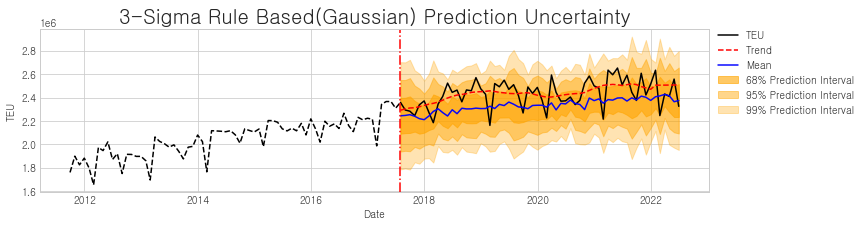

In [43]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.title('3-Sigma Rule Based(Gaussian) Prediction Uncertainty',fontsize=20)
#plt.ylim(1.7e6,2.9e6)
plt.plot(data['TEU'].iloc[140:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:], 'black', label='TEU')
plt.plot(trend,color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().mean()), label='Mean',color='blue',alpha=10.0)
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().mean() + 1*df2.transpose().std(),alpha=0)
plt.plot(df2.transpose().mean() - 1*df2.transpose().std(),color='darkblue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 1*df2.transpose().std(),df2.transpose().mean() + 1*df2.transpose().std(), alpha=0.6,color='orange', label='68% Prediction Interval')

plt.plot(df2.transpose().mean() + 2*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 2*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 2*df2.transpose().std(),df2.transpose().mean() + 2*df2.transpose().std(), alpha=0.45,color='orange', label='95% Prediction Interval')

plt.plot(df2.transpose().mean() + 3*df2.transpose().std(),color='blue',alpha=0)
plt.plot(df2.transpose().mean() - 3*df2.transpose().std(),color='blue',alpha=0)
plt.fill_between(df2.transpose().mean().index, df2.transpose().mean() - 3*df2.transpose().std(),df2.transpose().mean() + 3*df2.transpose().std(), alpha=0.3,color='orange',label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.00, 1.05), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.reset_index()['TEU'], df.transpose().mean()))
print('Mean RMSE:',rmse)
print('Mean MAPE:',np.mean(np.abs((test_data.reset_index()['TEU']- df.transpose().mean())/ test_data.reset_index()['TEU'])*100) )

In [44]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(60).reset_index()['TEU']
UCL = df.transpose().mean() + 2*df.transpose().std()
LCL = df.transpose().mean() - 2*df.transpose().std()

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.8666666666666667

In [45]:
# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.reset_index()['TEU_Trend']
UCL = df.transpose().mean() + 1*df.transpose().std()
LCL = df.transpose().mean() - 1*df.transpose().std()

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
CP

0.6166666666666667

In [46]:
#68% Interval sharpness score

lower = (df2.transpose().mean() - 1*df2.transpose().std()).values
upper = (df2.transpose().mean() + 1*df2.transpose().std()).values

sharpness = []
for i in range(0,60):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 68% Interval Sharpness',np.mean(np.array(sharpness)))

#68% Interval sharpness score

lower = df2.transpose().quantile(0.15).values
upper = df2.transpose().quantile(0.85).values

sharpness = []
for i in range(0,60):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 70% Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 68% Interval Sharpness 242158.64
Quantile 70% Interval Sharpness 230054.69541666665


Median RMSE: 151816.82072456286
Median MAPE: 5.223928172278459


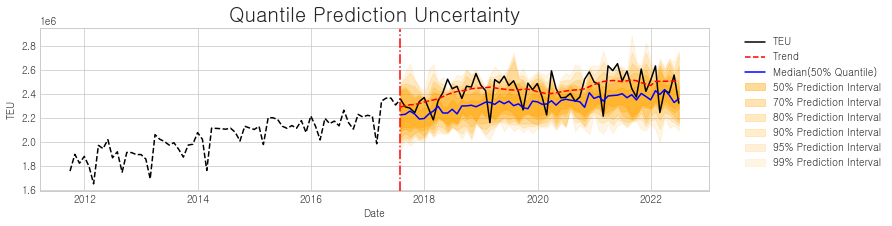

In [47]:
plt.figure(figsize=(12,3))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('TEU')
plt.title('Quantile Prediction Uncertainty',fontsize=20)
#plt.ylim(1.7e6,2.85e6)
plt.plot(data['TEU'].iloc[140:211], 'black',linestyle='dashed')
plt.plot(data['TEU'].iloc[210:], 'black', label='TEU')
plt.plot(trend,color='red',label='Trend',linestyle='dashed')
plt.plot(pd.DataFrame(df2.transpose().median()), label='Median(50% Quantile)',color='blue')
plt.axvline(x='2017-07-31', color='red',linestyle='dashdot')

plt.plot(df2.transpose().quantile(0.2),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.7),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.2),df2.transpose().quantile(0.7), alpha=0.4,color='orange', label='50% Prediction Interval')

plt.plot(df2.transpose().quantile(0.15),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.85),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.15),df2.transpose().quantile(0.85), alpha=0.3,color='orange', label='70% Prediction Interval')

plt.plot(df2.transpose().quantile(0.10),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.90),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.10),df2.transpose().quantile(0.90), alpha=0.23,color='orange', label='80% Prediction Interval')

plt.plot(df2.transpose().quantile(0.05),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.95),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.05),df2.transpose().quantile(0.95), alpha=0.2,color='orange', label='90% Prediction Interval')

plt.plot(df2.transpose().quantile(0.025),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.975),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.025),df2.transpose().quantile(0.975), alpha=0.15,color='orange', label='95% Prediction Interval')

plt.plot(df2.transpose().quantile(0.0),color='blue', alpha=0)
plt.plot(df2.transpose().quantile(0.99),color='blue', alpha=0)
plt.fill_between(df2.transpose().median().index, df2.transpose().quantile(0.0),df2.transpose().quantile(0.99), alpha=0.1,color='orange', label='99% Prediction Interval')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

rmse = math.sqrt(mean_squared_error(test_data.reset_index()['TEU'], df.transpose().quantile(0.5)))
print('Median RMSE:',rmse)
print('Median MAPE:',np.mean(np.abs((test_data.reset_index()['TEU']- df.transpose().quantile(0.5))/ test_data.reset_index()['TEU'])*100) )

In [48]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(60).reset_index()['TEU']
UCL = df.transpose().quantile(0.975)
LCL = df.transpose().quantile(0.025)

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.8333333333333334

In [49]:
# Coverage Probability 2. 추세 중심 68% Prediction Interval

trend_coverage = trend.reset_index()['TEU_Trend']
UCL = df.transpose().quantile(0.85)
LCL = df.transpose().quantile(0.15)

## The coverage probability
CP = np.mean( (trend_coverage > LCL) & (trend_coverage < UCL) )
CP

0.55

In [50]:
# Coverage Probability 1. 전체 데이터 95% Prediction Interval

test_coverage = test_data.head(60).reset_index()['TEU']
UCL = (df.transpose().max()+df.transpose().min())/2 + (df.transpose().max()-df.transpose().min())/2
LCL = (df.transpose().max()+df.transpose().min())/2 - (df.transpose().max()-df.transpose().min())/2

## The coverage probability
CP = np.mean( (test_coverage > LCL) & (test_coverage < UCL) )
CP

0.9333333333333333

In [51]:
#95% Interval sharpness score

lower = (df2.transpose().mean() - 2*df2.transpose().std()).values
upper = (df2.transpose().mean() + 2*df2.transpose().std()).values

sharpness = []
for i in range(0,60):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Gaussian 95% Interval Sharpness',np.mean(np.array(sharpness)))

#95% Interval sharpness score

lower = df2.transpose().quantile(0.025).values
upper = df2.transpose().quantile(0.975).values

sharpness = []
for i in range(0,60):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Quantile 95% Interval Sharpness',np.mean(np.array(sharpness)))

lower = df2.transpose().min().values
upper = df2.transpose().max().values

sharpness = []
for i in range(0,60):
    upper[i] - lower[i]
    sharpness.append(upper[i] - lower[i])
    
print('Min Max Interval Sharpness',np.mean(np.array(sharpness)))

Gaussian 95% Interval Sharpness 484317.22
Quantile 95% Interval Sharpness 427263.5424479165
Min Max Interval Sharpness 519581.56


In [52]:
import CRPS.CRPS as pscore

In [53]:
crps = []

for i in range(0,60):
    crps,fcrps,acrps = pscore(df.transpose()[i],test_data.tail(60).reset_index()['TEU'][i],adjusted_ensemble_size=30).compute()
    print(np.array(crps)) 

69303.47000000002
47622.09236111111
34159.93291666667
37787.53375
79688.66847222223
103227.30777777778
31856.497638888886
51784.61430555555
33015.58763888889
96785.02500000002
222175.51986111113
96108.58944444444
149121.63569444447
34069.57277777777
117830.75722222224
102412.67069444444
194994.17222222226
122322.15416666667
65062.06708333333
104246.41555555558
159892.00333333333
99307.45583333334
164289.4327777778
70625.17222222223
125219.0188888889
64661.91888888888
27485.899305555555
135752.9272222222
59112.134722222225
95693.0852777778
36612.21805555556
51282.576111111106
181103.7316666667
100158.6211111111
22967.12527777777
22442.161111111116
28204.286944444444
20729.122500000005
32334.948055555553
170799.85888888888
122753.01430555558
90856.12694444445
55923.80069444445
74759.11416666667
191123.0436111111
155721.94750000004
194082.42722222224
66945.82250000001
157213.18444444443
42541.81944444445
34809.569444444445
131333.04444444441
35203.03166666666
98967.23611111111
174934.5691

In [54]:
a = np.array([69303.47000000002,
47622.09236111111,
34159.93291666667,
37787.53375,
79688.66847222223,
103227.30777777778,
31856.497638888886,
51784.61430555555,
33015.58763888889,
96785.02500000002,
222175.51986111113,
96108.58944444444,
149121.63569444447,
34069.57277777777,
117830.75722222224,
102412.67069444444,
194994.17222222226,
122322.15416666667,
65062.06708333333,
104246.41555555558,
159892.00333333333,
99307.45583333334,
164289.4327777778,
70625.17222222223,
125219.0188888889,
64661.91888888888,
27485.899305555555,
135752.9272222222,
59112.134722222225,
95693.0852777778,
36612.21805555556,
51282.576111111106,
181103.7316666667,
100158.6211111111,
22967.12527777777,
22442.161111111116,
28204.286944444444,
20729.122500000005,
32334.948055555553,
170799.85888888888,
122753.01430555558,
90856.12694444445,
55923.80069444445,
74759.11416666667,
191123.0436111111,
155721.94750000004,
194082.42722222224,
66945.82250000001,
157213.18444444443,
42541.81944444445,
34809.569444444445,
131333.04444444441,
35203.03166666666,
98967.23611111111,
174934.56916666665,
102361.02013888893,
21073.413333333334,
32205.214166666665,
133826.6413888889,
30345.035138888892,])

In [55]:
a.shape

(60,)

In [56]:
np.mean(a)

90153.78431018516

In [57]:
(90153.78+100178.23+100735.97)/3

97022.65999999999

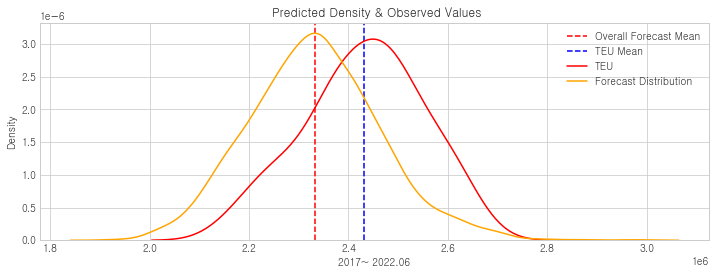

In [58]:
plt.figure(figsize=(12,4))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=df.transpose().mean().mean(), color='red',linestyle='dashed',label='Overall Forecast Mean')
plt.axvline(x=test_data.mean(), color='blue',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.reset_index()['TEU'],color='red',label='TEU',hist=False)
sns.distplot(df.transpose(),color='orange',label='Forecast Distribution',hist=False)
plt.xlabel('2017~ 2022.06')
plt.legend()

In [59]:
def KL(p,q):
    return(np.abs(sum(p*np.log(p/q))))

In [60]:
for i in range(0,30):
    print(KL(df[i],test_data.reset_index()['TEU']))

4676193.081952994
4606120.968271388
5346015.652444678
5639384.963719238
2946143.4961877847
5095594.560657258
5763595.378920073
5326789.481888545
5349687.150126958
4815510.666118307
6117567.825254457
5687455.156743447
4764523.962263014
5494638.269587972
7019087.078340998
6293824.479175567
5095536.279858494
5551552.590767746
6169942.265241208
6041249.297517272
6980742.236174269
5962641.252150327
4897633.548966307
5547854.397629156
5350695.816652659
4783082.227298178
5517067.128014547
4933501.865487213
6924709.060211904
5015756.051851825


In [61]:
a = np.array([4676193.081952994,
4606120.968271388,
5346015.652444678,
5639384.963719238,
2946143.4961877847,
5095594.560657258,
5763595.378920073,
5326789.481888545,
5349687.150126958,
4815510.666118307,
6117567.825254457,
5687455.156743447,
4764523.962263014,
5494638.269587972,
7019087.078340998,
6293824.479175567,
5095536.279858494,
5551552.590767746,
6169942.265241208,
6041249.297517272,
6980742.236174269,
5962641.252150327,
4897633.548966307,
5547854.397629156,
5350695.816652659,
4783082.227298178,
5517067.128014547,
4933501.865487213,
6924709.060211904,
5015756.051851825])

In [62]:
np.mean(a)

5457136.539649126

In [63]:
from scipy.stats import norm
import numpy as np

weight_grid = np.array(df).reshape(-1)

likelihoods = [
  np.sum(norm(weight_guess,df.transpose().mean().std()).logpdf(df))
  for weight_guess in weight_grid
]
weight = weight_grid[np.argmax(likelihoods)]

In [64]:
weight

2331818.2

In [71]:
df.to_csv('TCN.csv')

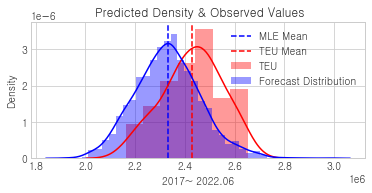

In [65]:
plt.figure(figsize=(6,2.5))
plt.title(' Predicted Density & Observed Values')
plt.axvline(x=weight, color='blue',linestyle='dashed',label='MLE Mean')
plt.axvline(x=test_data.mean(), color='red',linestyle='dashed',label='TEU Mean')
sns.distplot(test_data.reset_index()['TEU'],color='red',label='TEU',hist=True)
sns.distplot(df.transpose(),color='blue',label='Forecast Distribution',hist=True)
plt.xlabel('2017~ 2022.06')
plt.legend()

In [66]:
from scipy.stats import norm

In [67]:
from scipy.stats import norm
from scipy import stats
from scipy.optimize import minimize
from scipy.optimize import minimize

LL = -np.sum( stats.norm.logpdf(df, loc=test_data.reset_index()['TEU'].mean(), scale=test_data.reset_index()['TEU'].std() ) )
LL

24417.400663932545

In [68]:
LL = -np.sum( stats.norm.logpdf(df, loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

26587.860320934262

In [69]:
LL = -np.sum(stats.norm.logpdf(df, loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

26587.860320934262

In [70]:
LL = -np.sum( stats.norm.logpdf(test_data.reset_index()['TEU'], loc=df.transpose().mean().mean(), scale=df.transpose().mean().std() ) )
LL

948.5340814801956